In [1]:
pip install prettytable lazypredict shap imbalanced-learn tensorflow

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
import io
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error,r2_score, recall_score, precision_score, f1_score
from math import sqrt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable
import shap
from lazypredict.Supervised import LazyClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Dataset

In [3]:
emp_data = pd.read_csv('employee_data.csv',sep=r'\s*,\s*',header=0, engine='python') # removes the spaces in the data too to avoid naming issues (sep=r'\s*,\s*)
emp_data_filtered =  emp_data.drop(columns=['joined_date','resigned_date'],inplace=False) #inplace=True changes the original df than returning a copy  <---- without joined and resigned date
emp_data_filtered.head()

age_category  gender            marital_status educational_status  \
0      20 - 30  Female     Married with children     Diploma holder   
1      20 - 30  Female  Married without children     Diploma holder   
2      30 - 40  Female  Married without children     Diploma holder   
3      20 - 30    Male     Married with children     Diploma holder   
4      20 - 30    Male                    Single     Diploma holder   

  total_years_industry years_work_current_hotel number_of_years_current_role  \
0          3 - 5 years              3 - 5 years                  3 - 5 years   
1          1 - 3 years         Less than 1 year             Less than 1 year   
2         5 - 10 years              1 - 3 years                  1 - 3 years   
3          3 - 5 years              3 - 5 years                  1 - 3 years   
4          3 - 5 years              1 - 3 years                  1 - 3 years   

           department  working_hours  promotional_barriers  work_life_balance  \
0        Front office              4                     4                  5   
1        Housekeeping              5                     5                  4   
2        Housekeeping              5                     5                  5   
3  Food and Beverages              5                     4                  5   
4  Food and Beverages              4                     5                  5   

   status_and_recognition  salary  opportunities  workload  work_environment  \
0                       3       5              3         4                 5   
1                       3       5              5         5                 4   
2                       3       5              5         5                 5   
3                       3       5              4         5                 5   
4                       5       5              5         5                 5   

   training_and_development  relationship_with_colleagues  \
0                         5                             5   
1                         5                             4   
2                         3                             3   
3                         4                             4   
4                         3                             5   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
0                             5                 5                   4   
1                             5                 5                   3   
2                             3                 4                   5   
3                             5                 5                   3   
4                             4                 5                   2   

  last_promotion hotel_assess_performance intend_to_leave  
0    1 - 3 years              Quite often              No  
1  None received               Less Often             Yes  
2  None received               Less Often             Yes  
3    1 - 3 years                    Often              No  
4  None received               Less Often             Yes

## Data Preprocessing

### Dimensional Reduction


*   cardinality validation

In [4]:
#for the continuous attributes
continous_attributues = emp_data_filtered.loc[:, ['working_hours','promotional_barriers','work_life_balance','status_and_recognition','salary','opportunities','workload','work_environment','training_and_development','relationship_with_colleagues','relationship_with_supervisor','job_satisfaction','distance_from_home']]
continous_attributues.head()

working_hours  promotional_barriers  work_life_balance  \
0              4                     4                  5   
1              5                     5                  4   
2              5                     5                  5   
3              5                     4                  5   
4              4                     5                  5   

   status_and_recognition  salary  opportunities  workload  work_environment  \
0                       3       5              3         4                 5   
1                       3       5              5         5                 4   
2                       3       5              5         5                 5   
3                       3       5              4         5                 5   
4                       5       5              5         5                 5   

   training_and_development  relationship_with_colleagues  \
0                         5                             5   
1                         5                             4   
2                         3                             3   
3                         4                             4   
4                         3                             5   

   relationship_with_supervisor  job_satisfaction  distance_from_home  
0                             5                 5                   4  
1                             5                 5                   3  
2                             3                 4                   5  
3                             5                 5                   3  
4                             4                 5                   2

In [5]:
continous_attributues_data_types = pd.DataFrame(emp_data_filtered[continous_attributues.columns].dtypes,columns=['Data Type']) # data types
continous_attributues_cardinality = pd.DataFrame(emp_data_filtered[continous_attributues.columns].nunique(),columns=['Cardinality']) # number of unique categories in the column
continous_attributues_min = pd.DataFrame(emp_data_filtered[continous_attributues.columns].min(),columns=['Min']) # minimum value in the column
continous_attributues_max = pd.DataFrame(emp_data_filtered[continous_attributues.columns].max(),columns=['Max']) # maximum value in the column
continous_attributues_mean = pd.DataFrame(emp_data_filtered[continous_attributues.columns].mean(),columns=['Mean']) # mean value in the column

continous_attributues_analytics =  continous_attributues_data_types.join(continous_attributues_cardinality).join(continous_attributues_min).join(continous_attributues_max).join(continous_attributues_mean)
continous_attributues_analytics

Data Type  Cardinality  Min  Max  Mean
working_hours                    int64            5    1    5  3.95
promotional_barriers             int64            5    1    5  3.87
work_life_balance                int64            5    1    5  3.81
status_and_recognition           int64            5    1    5  3.75
salary                           int64            5    1    5  4.30
opportunities                    int64            5    1    5  3.96
workload                         int64            5    1    5  4.02
work_environment                 int64            5    1    5  3.85
training_and_development         int64            5    1    5  3.62
relationship_with_colleagues     int64            5    1    5  3.67
relationship_with_supervisor     int64            5    1    5  3.94
job_satisfaction                 int64            5    1    5  4.10
distance_from_home               int64            5    1    5  3.53

In [6]:
#for the categorical attributes
categorical_attributues = emp_data_filtered.loc[:, ['age_category','gender','marital_status','educational_status','total_years_industry','years_work_current_hotel','number_of_years_current_role','department','last_promotion','hotel_assess_performance','intend_to_leave']]
categorical_attributues.head()

age_category  gender            marital_status educational_status  \
0      20 - 30  Female     Married with children     Diploma holder   
1      20 - 30  Female  Married without children     Diploma holder   
2      30 - 40  Female  Married without children     Diploma holder   
3      20 - 30    Male     Married with children     Diploma holder   
4      20 - 30    Male                    Single     Diploma holder   

  total_years_industry years_work_current_hotel number_of_years_current_role  \
0          3 - 5 years              3 - 5 years                  3 - 5 years   
1          1 - 3 years         Less than 1 year             Less than 1 year   
2         5 - 10 years              1 - 3 years                  1 - 3 years   
3          3 - 5 years              3 - 5 years                  1 - 3 years   
4          3 - 5 years              1 - 3 years                  1 - 3 years   

           department last_promotion hotel_assess_performance intend_to_leave  
0        Front office    1 - 3 years              Quite often              No  
1        Housekeeping  None received               Less Often             Yes  
2        Housekeeping  None received               Less Often             Yes  
3  Food and Beverages    1 - 3 years                    Often              No  
4  Food and Beverages  None received               Less Often             Yes

In [7]:
categorical_attributues_data_types = pd.DataFrame(emp_data_filtered[categorical_attributues.columns].dtypes,columns=['Data Type']) # data types
categorical_attributues_cardinality = pd.DataFrame(emp_data_filtered[categorical_attributues.columns].nunique(),columns=['Cardinality']) # number of unique categories in the column
categorical_attributues_analytics =  categorical_attributues_data_types.join(categorical_attributues_cardinality)
categorical_attributues_analytics

Data Type  Cardinality
age_category                    object            3
gender                          object            2
marital_status                  object            3
educational_status              object            5
total_years_industry            object            6
years_work_current_hotel        object            6
number_of_years_current_role    object            6
department                      object            5
last_promotion                  object            6
hotel_assess_performance        object            3
intend_to_leave                 object            2

since all columns cardinality is greater than one no columns to drop

*   corerelation validation


In [8]:
corr_matrix = emp_data_filtered.corr().abs()
upper_trangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_trangle.columns if any(upper_trangle[column] > 0.95)]
print("columns to drop: ",to_drop)

columns to drop:  []


### Mising Values Handling

In [9]:
emp_data_filtered.isna().sum() # this step shows the number of missing/null values in the dataset

age_category                    0
gender                          0
marital_status                  0
educational_status              0
total_years_industry            0
years_work_current_hotel        0
number_of_years_current_role    0
department                      0
working_hours                   0
promotional_barriers            0
work_life_balance               0
status_and_recognition          0
salary                          0
opportunities                   0
workload                        0
work_environment                0
training_and_development        0
relationship_with_colleagues    0
relationship_with_supervisor    0
job_satisfaction                0
distance_from_home              0
last_promotion                  0
hotel_assess_performance        0
intend_to_leave                 0
dtype: int64

since there is no null values in this dataset, it is possible to continue with this dataset

### Data Encording

by analyzing the dataset it is possible to see that there few coulumns with with non-numeric data. Since Machine Learning models primarily based on mathematical equations data should be in numerical format. Therefore it is need to convert non-numerical values into numerical values.

In [10]:
# using pandas get_dummies method non-numerical values encords into numerical values based on One-Hot technique
non_numeric_value_cols =['age_category','gender','marital_status','educational_status','total_years_industry','years_work_current_hotel','number_of_years_current_role','department','last_promotion','hotel_assess_performance']
encoded_emp_data = pd.DataFrame(pd.get_dummies(emp_data_filtered, dummy_na=False,columns=non_numeric_value_cols,dtype=np.int64))

# for the Attrition column using Label Encording technique for scaling ( should be in one column and outputs only yes/no) 
encoded_emp_data['intend_to_leave'] = LabelEncoder().fit_transform(emp_data_filtered['intend_to_leave'])

encoded_emp_data.dtypes

working_hours                                      int64
promotional_barriers                               int64
work_life_balance                                  int64
status_and_recognition                             int64
salary                                             int64
opportunities                                      int64
workload                                           int64
work_environment                                   int64
training_and_development                           int64
relationship_with_colleagues                       int64
relationship_with_supervisor                       int64
job_satisfaction                                   int64
distance_from_home                                 int64
intend_to_leave                                    int32
age_category_20 - 30                               int64
age_category_30 - 40                               int64
age_category_Above 40                              int64
gender_Female                  

In [11]:
encoded_emp_data.head()

working_hours  promotional_barriers  work_life_balance  \
0              4                     4                  5   
1              5                     5                  4   
2              5                     5                  5   
3              5                     4                  5   
4              4                     5                  5   

   status_and_recognition  salary  opportunities  workload  work_environment  \
0                       3       5              3         4                 5   
1                       3       5              5         5                 4   
2                       3       5              5         5                 5   
3                       3       5              4         5                 5   
4                       5       5              5         5                 5   

   training_and_development  relationship_with_colleagues  \
0                         5                             5   
1                         5                             4   
2                         3                             3   
3                         4                             4   
4                         3                             5   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
0                             5                 5                   4   
1                             5                 5                   3   
2                             3                 4                   5   
3                             5                 5                   3   
4                             4                 5                   2   

   intend_to_leave  age_category_20 - 30  age_category_30 - 40  \
0                0                     1                     0   
1                1                     1                     0   
2                1                     0                     1   
3                0                     1                     0   
4                1                     1                     0   

   age_category_Above 40  gender_Female  gender_Male  \
0                      0              1            0   
1                      0              1            0   
2                      0              1            0   
3                      0              0            1   
4                      0              0            1   

   marital_status_Married with children  \
0                                     1   
1                                     0   
2                                     0   
3                                     1   
4                                     0   

   marital_status_Married without children  marital_status_Single  \
0                                        0                      0   
1                                        1                      0   
2                                        1                      0   
3                                        0                      0   
4                                        0                      1   

   educational_status_A/L passer  educational_status_Below O/L  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   educational_status_Degree holder  educational_status_Diploma holder  \
0                                 0                                  1   
1                                 0                                  1   
2                                 0                                  1   
3                                 0                                  1   
4                                 0                                  1   

   educational_status_O/L passer  total_years_industry_1 - 3 years  \
0                            

### Imbalnced Data Handling

In [12]:
emp_data_with_attr_features = encoded_emp_data.drop("intend_to_leave", axis=1)
emp_data_with_attr_output = encoded_emp_data["intend_to_leave"]

print("Employee Attrition=True Count: " +str(len(emp_data_with_attr_output[emp_data_with_attr_output==1])))
print("Employee Attrition=False Count: " +str(len(emp_data_with_attr_output[emp_data_with_attr_output==0]))+"\n")

Employee Attrition=True Count: 155
Employee Attrition=False Count: 90



By analyzing the above results, it is possible to see that the Attrition class(Output) is imbalanced. As a result, predicting the majority class may get pretty high accuracy. Therefore it is required to deal with this problem. For that, SMOTE algorithm will use to balance the dataset because many researchers recommend this algorithm.

In [13]:
balanced_emp_data_with_attr_features,balanced_emp_data_with_attr_output = SMOTE().fit_resample(emp_data_with_attr_features, emp_data_with_attr_output)

print("Employee Attrition=True Count: " +str(len(balanced_emp_data_with_attr_output[balanced_emp_data_with_attr_output==1])))
print("Employee Attrition=False Count: " +str(len(balanced_emp_data_with_attr_output[balanced_emp_data_with_attr_output==0]))+"\n")

Employee Attrition=True Count: 155
Employee Attrition=False Count: 155



In [14]:
balanced_emp_data = balanced_emp_data_with_attr_features.join(balanced_emp_data_with_attr_output)
balanced_emp_data.head()

working_hours  promotional_barriers  work_life_balance  \
0              4                     4                  5   
1              5                     5                  4   
2              5                     5                  5   
3              5                     4                  5   
4              4                     5                  5   

   status_and_recognition  salary  opportunities  workload  work_environment  \
0                       3       5              3         4                 5   
1                       3       5              5         5                 4   
2                       3       5              5         5                 5   
3                       3       5              4         5                 5   
4                       5       5              5         5                 5   

   training_and_development  relationship_with_colleagues  \
0                         5                             5   
1                         5                             4   
2                         3                             3   
3                         4                             4   
4                         3                             5   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
0                             5                 5                   4   
1                             5                 5                   3   
2                             3                 4                   5   
3                             5                 5                   3   
4                             4                 5                   2   

   age_category_20 - 30  age_category_30 - 40  age_category_Above 40  \
0                     1                     0                      0   
1                     1                     0                      0   
2                     0                     1                      0   
3                     1                     0                      0   
4                     1                     0                      0   

   gender_Female  gender_Male  marital_status_Married with children  \
0              1            0                                     1   
1              1            0                                     0   
2              1            0                                     0   
3              0            1                                     1   
4              0            1                                     0   

   marital_status_Married without children  marital_status_Single  \
0                                        0                      0   
1                                        1                      0   
2                                        1                      0   
3                                        0                      0   
4                                        0                      1   

   educational_status_A/L passer  educational_status_Below O/L  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   educational_status_Degree holder  educational_status_Diploma holder  \
0                                 0                                  1   
1                                 0                                  1   
2                                 0                                  1   
3                                 0                                  1   
4                                 0                                  1   

   educational_status_O/L passer  total_years_industry_1 - 3 years  \
0                              0                                 0   
1                              0                                 1   
2                     

### Dupplicate Values Handling

In [15]:
print("before removal dupplication data: ",balanced_emp_data.shape[0])
balanced_emp_data.drop_duplicates(inplace = True)
print("after removal dupplication data: ",balanced_emp_data.shape[0])

before removal dupplication data:  310
after removal dupplication data:  299


### Feature Scaling

*   applying min-max scaling to the dataset

In [16]:
min_max_scaler=MinMaxScaler()
min_max_scaler.fit(balanced_emp_data)

encoded_balanced_mx_scaled_emp_data = pd.DataFrame(min_max_scaler.transform(balanced_emp_data.to_numpy()),columns=balanced_emp_data.columns)
encoded_balanced_mx_scaled_emp_data.head()

working_hours  promotional_barriers  work_life_balance  \
0           0.75                  0.75               1.00   
1           1.00                  1.00               0.75   
2           1.00                  1.00               1.00   
3           1.00                  0.75               1.00   
4           0.75                  1.00               1.00   

   status_and_recognition  salary  opportunities  workload  work_environment  \
0                    0.50    1.00           0.50      0.75              1.00   
1                    0.50    1.00           1.00      1.00              0.75   
2                    0.50    1.00           1.00      1.00              1.00   
3                    0.50    1.00           0.75      1.00              1.00   
4                    1.00    1.00           1.00      1.00              1.00   

   training_and_development  relationship_with_colleagues  \
0                      1.00                          1.00   
1                      1.00                          0.75   
2                      0.50                          0.50   
3                      0.75                          0.75   
4                      0.50                          1.00   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
0                          1.00              1.00                0.75   
1                          1.00              1.00                0.50   
2                          0.50              0.75                1.00   
3                          1.00              1.00                0.50   
4                          0.75              1.00                0.25   

   age_category_20 - 30  age_category_30 - 40  age_category_Above 40  \
0                  1.00                  0.00                   0.00   
1                  1.00                  0.00                   0.00   
2                  0.00                  1.00                   0.00   
3                  1.00                  0.00                   0.00   
4                  1.00                  0.00                   0.00   

   gender_Female  gender_Male  marital_status_Married with children  \
0           1.00         0.00                                  1.00   
1           1.00         0.00                                  0.00   
2           1.00         0.00                                  0.00   
3           0.00         1.00                                  1.00   
4           0.00         1.00                                  0.00   

   marital_status_Married without children  marital_status_Single  \
0                                     0.00                   0.00   
1                                     1.00                   0.00   
2                                     1.00                   0.00   
3                                     0.00                   0.00   
4                                     0.00                   1.00   

   educational_status_A/L passer  educational_status_Below O/L  \
0                           0.00                          0.00   
1                           0.00                          0.00   
2                           0.00                          0.00   
3                           0.00                          0.00   
4                           0.00                          0.00   

   educational_status_Degree holder  educational_status_Diploma holder  \
0                              0.00                               1.00   
1                              0.00                               1.00   
2                              0.00                               1.00   
3                              0.00                               1.00   
4                              0.00                               1.00   

   educational_status_O/L passer  total_years_industry_1 - 3 years  \
0                           0.00                              0.00   
1                           0.00                              1.00   
2                     

## Data Splitting

In the below step, data is split into 70:30 ratios. This means 70% of the total data is for training and 30% for testing

In [17]:
encoded_features_train, encoded_features_test , encoded_output_train, encoded_output_test = train_test_split(balanced_emp_data.drop("intend_to_leave", axis=1),balanced_emp_data['intend_to_leave'],train_size=0.7) # encoded , balanced
mx_features_train, mx_features_test , mx_output_train, mx_output_test = train_test_split(encoded_balanced_mx_scaled_emp_data.drop("intend_to_leave", axis=1),encoded_balanced_mx_scaled_emp_data['intend_to_leave'],train_size=0.7) # encoded , balanced, sclaed

## Model Selection

*   selection with encoded balanced without scaled data

In [18]:
np.random.seed(0)
lazy_classifier = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy_classifier.fit(encoded_features_train, encoded_features_test, encoded_output_train, encoded_output_test)
models.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 34.79it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                        
ExtraTreesClassifier            0.98               0.98     0.98      0.98   
XGBClassifier                   0.97               0.96     0.96      0.97   
RandomForestClassifier          0.97               0.96     0.96      0.97   
SVC                             0.94               0.95     0.95      0.94   
NuSVC                           0.94               0.95     0.95      0.94   
LGBMClassifier                  0.94               0.94     0.94      0.94   
DecisionTreeClassifier          0.93               0.93     0.93      0.93   
BaggingClassifier               0.92               0.92     0.92      0.92   
KNeighborsClassifier            0.91               0.91     0.91      0.91   
LinearDiscriminantAnalysis      0.91               0.91     0.91      0.91   

                            Time Taken  
Model                                   
ExtraTreesClassifier              0.09  
XGBClassifier                     0.05  
RandomForestClassifier            0.13  
SVC                               0.01  
NuSVC                             0.04  
LGBMClassifier                    0.06  
DecisionTreeClassifier            0.02  
BaggingClassifier                 0.03  
KNeighborsClassifier              0.00  
LinearDiscriminantAnalysis        0.01

*   selection with min-max scaled data

In [19]:
np.random.seed(1)
mx_lazy_classifier = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
mx_models,mx_predictions = mx_lazy_classifier.fit(mx_features_train, mx_features_test, mx_output_train, mx_output_test)
mx_models.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 35.76it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                        
RidgeClassifierCV               0.97               0.97     0.97      0.97   
BaggingClassifier               0.97               0.97     0.97      0.97   
ExtraTreesClassifier            0.97               0.97     0.97      0.97   
LGBMClassifier                  0.96               0.96     0.96      0.96   
LinearDiscriminantAnalysis      0.96               0.96     0.96      0.96   
DecisionTreeClassifier          0.96               0.96     0.96      0.96   
RidgeClassifier                 0.96               0.96     0.96      0.96   
LogisticRegression              0.96               0.96     0.96      0.96   
XGBClassifier                   0.94               0.95     0.95      0.94   
LinearSVC                       0.94               0.95     0.95      0.94   

                            Time Taken  
Model                                   
RidgeClassifierCV                 0.01  
BaggingClassifier                 0.02  
ExtraTreesClassifier              0.12  
LGBMClassifier                    0.05  
LinearDiscriminantAnalysis        0.02  
DecisionTreeClassifier            0.02  
RidgeClassifier                   0.03  
LogisticRegression                0.02  
XGBClassifier                     0.05  
LinearSVC                         0.02

Analyzing the accuracy matrices in the above results makes it possible to see how algorithms performed on given datasets. From the above algorithms, the author is taking the top resulted algorithms to continue with the next steps. 

**When validating multiple times, the above results change slightly at some points. as with multiple validations, the below algorithms have been chosen to train, test, and validate.**

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron

In [21]:
bgg = BaggingClassifier(DecisionTreeClassifier())
lgmc = lgb.LGBMClassifier()
xgb = XGBClassifier(objective="binary:logistic")
bnb = BernoulliNB()
rfc =  RandomForestClassifier()
svc = SVC()
etc = ExtraTreesClassifier()
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
lr = LogisticRegression()

results_table = PrettyTable(["Algorithm Name","Train Score","Test Score(Accuracy)", "R2 Score", "MSE Score","F1 Score","Precision Score","Recall Score"])
for model in (bgg,lgmc,xgb,bnb,rfc,svc,etc,abc,lr):

  np.random.seed(2222)
  model.fit(encoded_features_train,encoded_output_train)
  model_predictions_std = model.predict(encoded_features_test)

  model_train_score = model.score(encoded_features_train,encoded_output_train)
  model_test_score = model.score(encoded_features_test,encoded_output_test)
  model_f1_score = f1_score(encoded_output_test, model_predictions_std, average='binary')
  model_precision_score=precision_score(encoded_output_test, model_predictions_std, average='binary')
  model_recall_score=recall_score(encoded_output_test, model_predictions_std, average='binary')
  model_r2_score = r2_score(encoded_output_test,model_predictions_std)
  model_mse_score=mean_squared_error(encoded_output_test, model_predictions_std)

  results_table.add_row([model.__class__.__name__,round(model_train_score*100,2), 
                      round(model_test_score*100,2), round(model_r2_score*100,2), 
                      round(model_mse_score*100,2), round(model_f1_score*100,2), 
                      round(model_precision_score*100,2), 
                      round(model_recall_score*100,2)])

print(results_table)

+------------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+
|     Algorithm Name     | Train Score | Test Score(Accuracy) | R2 Score | MSE Score | F1 Score | Precision Score | Recall Score |
+------------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+
|   BaggingClassifier    |    100.0    |        96.67         |  86.61   |    3.33   |   96.3   |      100.0      |    92.86     |
|     LGBMClassifier     |    100.0    |        94.44         |  77.68   |    5.56   |  93.83   |      97.44      |    90.48     |
|     XGBClassifier      |    100.0    |        96.67         |  86.61   |    3.33   |   96.3   |      100.0      |    92.86     |
|      BernoulliNB       |    91.87    |        88.89         |  55.36   |   11.11   |  87.18   |      94.44      |    80.95     |
| RandomForestClassifier |    100.0    |        96.67         |  86.61   |    3.33 

In [22]:
mx_dtc = DecisionTreeClassifier()
mx_bgg = BaggingClassifier(DecisionTreeClassifier())
mx_pac = PassiveAggressiveClassifier()
mx_lr = LogisticRegression()
mx_rfc =  RandomForestClassifier()
mx_ppt = Perceptron()
mx_etc = ExtraTreesClassifier()
mx_abc = AdaBoostClassifier(n_estimators=100, random_state=0)
mx_lgmc = lgb.LGBMClassifier()
mx_svc = SVC()
mx_xgb = XGBClassifier(objective="binary:logistic")

mx_results_table = PrettyTable(["Algorithm Name","Train Score","Test Score(Accuracy)", "R2 Score", "MSE Score","F1 Score","Precision Score","Recall Score"])
for model_mx in (mx_dtc,mx_bgg,mx_pac,mx_lr,mx_rfc,mx_ppt,mx_etc,mx_abc,mx_lgmc,mx_svc,mx_xgb):

  np.random.seed(333)
  model_mx.fit(mx_features_train,mx_output_train)
  model_predictions_mx = model_mx.predict(mx_features_test)

  model_train_score = model_mx.score(mx_features_train,mx_output_train)
  model_test_score = model_mx.score(mx_features_test,mx_output_test)
  model_f1_score = f1_score(mx_output_test, model_predictions_mx, average='binary')
  model_precision_score=precision_score(mx_output_test, model_predictions_mx, average='binary')
  model_recall_score=recall_score(mx_output_test, model_predictions_mx, average='binary')
  model_r2_score = r2_score(mx_output_test,model_predictions_mx)
  model_mse_score=mean_squared_error(mx_output_test, model_predictions_mx)

  mx_results_table.add_row([model_mx.__class__.__name__,round(model_train_score*100,2), 
                      round(model_test_score*100,2), round(model_r2_score*100,2), 
                      round(model_mse_score*100,2), round(model_f1_score*100,2), 
                      round(model_precision_score*100,2), 
                      round(model_recall_score*100,2)])

print(mx_results_table)

+-----------------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+
|        Algorithm Name       | Train Score | Test Score(Accuracy) | R2 Score | MSE Score | F1 Score | Precision Score | Recall Score |
+-----------------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+
|    DecisionTreeClassifier   |    100.0    |        94.44         |  77.68   |    5.56   |  94.51   |      100.0      |    89.58     |
|      BaggingClassifier      |    99.52    |        95.56         |  82.14   |    4.44   |  95.65   |      100.0      |    91.67     |
| PassiveAggressiveClassifier |    98.56    |        95.56         |  82.14   |    4.44   |  95.74   |      97.83      |    93.75     |
|      LogisticRegression     |    97.61    |        92.22         |  68.75   |    7.78   |  92.47   |      95.56      |    89.58     |
|    RandomForestClassifier   |    100.0    |   

It is possible to see from the above results, ExtraTreesClassifier algorithm is performing well for non scaled encoded type data. As it is author decided to continue this system with ExtraTreesClassifier     Algorithm as the final algotithm predict employee early turnover.

## Model Tuning

In [23]:
parameters = {
    'criterion': ["gini", "entropy"],
    'n_estimators': [11, 20,22,50,70,100],
    'min_samples_leaf': [1, 2, 5, 7, 9],
    'max_features': ['auto', 'sqrt', 'log2', 1,2, 10,29, None],
    'max_depth': [1,5,10,20,None],
    'max_leaf_nodes': [1,10,20,100, None],
}
kfold_values = StratifiedKFold(n_splits=5)

>2, train: 0.933, test: 0.889
>3, train: 0.947, test: 0.911
>4, train: 0.976, test: 0.967
>5, train: 0.986, test: 0.989
>6, train: 0.990, test: 0.989
>7, train: 0.995, test: 0.989
>8, train: 0.995, test: 0.989
>9, train: 1.000, test: 0.989
>10, train: 1.000, test: 0.989
>11, train: 1.000, test: 0.978
>12, train: 1.000, test: 0.989
>13, train: 1.000, test: 0.978
>14, train: 1.000, test: 0.967
>15, train: 1.000, test: 0.978
>16, train: 1.000, test: 0.978
>17, train: 1.000, test: 0.978
>18, train: 1.000, test: 0.989
>19, train: 1.000, test: 0.989
>20, train: 1.000, test: 0.978
>21, train: 1.000, test: 0.978
>22, train: 1.000, test: 0.978
>23, train: 1.000, test: 0.978
>24, train: 1.000, test: 1.000
>25, train: 1.000, test: 0.978
>26, train: 1.000, test: 0.989
>27, train: 1.000, test: 0.967
>28, train: 1.000, test: 0.978
>29, train: 1.000, test: 0.978
>30, train: 1.000, test: 0.989
>31, train: 1.000, test: 0.967
>32, train: 1.000, test: 0.989
>33, train: 1.000, test: 0.989
>34, train: 1.00

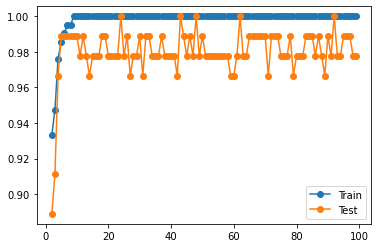

In [36]:
values = [i for i in range(2,100)]
train_scores, test_scores = list(), list()
for i in values:
  model2 = ExtraTreesClassifier(max_depth=i)
  model2.fit(encoded_features_train,encoded_output_train)
  train_yhat = model2.predict(encoded_features_train)
  train_acc = accuracy_score(encoded_output_train, train_yhat)
  train_scores.append(train_acc)
   # evaluate on the test dataset
  test_yhat = model2.predict(encoded_features_test)
  test_acc = accuracy_score(encoded_output_test, test_yhat)
  test_scores.append(test_acc)
  # summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [25]:
# lgbm_tuned = lgb.LGBMClassifier()
# lgbm_model_with_hparms = GridSearchCV(lgbm_tuned, parameters, scoring="accuracy", n_jobs=2, cv=kfold_values)
# lgbm_model_with_hparms.fit(encoded_features_train,encoded_output_train)
# lgbm_model_with_hparms.best_params_

In [37]:
best_params ={'criterion': 'gini',
 'max_depth': 43,
 'max_features': 5,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 2,
 'n_estimators': 11}

In [42]:
tuned_results_table = PrettyTable(["Algorithm Name","Train Score","Test Score(Accuracy)", "R2 Score", "MSE Score","F1 Score","Precision Score","Recall Score"])

tuned_classifier = ExtraTreesClassifier(**best_params)    

tuned_classifier.fit(encoded_features_train,encoded_output_train)
model_predictions = tuned_classifier.predict(encoded_features_test)

model_train_score = tuned_classifier.score(encoded_features_train,encoded_output_train)
model_test_score = tuned_classifier.score(encoded_features_test,encoded_output_test)
model_f1_score = f1_score(encoded_output_test, model_predictions, average='binary')
model_precision_score=precision_score(encoded_output_test, model_predictions, average='binary')
model_recall_score=recall_score(encoded_output_test, model_predictions, average='binary')
model_r2_score = r2_score(encoded_output_test,model_predictions)
model_mse_score=mean_squared_error(encoded_output_test, model_predictions)

tuned_results_table.add_row([tuned_classifier.__class__.__name__,round(model_train_score*100,2), 
                      round(model_test_score*100,2), round(model_r2_score*100,2), 
                      round(model_mse_score*100,2), round(model_f1_score*100,2), 
                      round(model_precision_score*100,2), 
                      round(model_recall_score*100,2)])

print(tuned_results_table)

+----------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+
|    Algorithm Name    | Train Score | Test Score(Accuracy) | R2 Score | MSE Score | F1 Score | Precision Score | Recall Score |
+----------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+
| ExtraTreesClassifier |    99.04    |        98.89         |  95.54   |    1.11   |   98.8   |      100.0      |    97.62     |
+----------------------+-------------+----------------------+----------+-----------+----------+-----------------+--------------+


## Model Export

In [44]:
import pickle
pickle.dump(tuned_classifier, open('employee_turnover_extra_tree_classifier.pkl', 'wb'))

## Application

In [45]:
balanced_emp_data.iloc[[1]]

working_hours  promotional_barriers  work_life_balance  \
1              5                     5                  4   

   status_and_recognition  salary  opportunities  workload  work_environment  \
1                       3       5              5         5                 4   

   training_and_development  relationship_with_colleagues  \
1                         5                             4   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
1                             5                 5                   3   

   age_category_20 - 30  age_category_30 - 40  age_category_Above 40  \
1                     1                     0                      0   

   gender_Female  gender_Male  marital_status_Married with children  \
1              1            0                                     0   

   marital_status_Married without children  marital_status_Single  \
1                                        1                      0   

   educational_status_A/L passer  educational_status_Below O/L  \
1                              0                             0   

   educational_status_Degree holder  educational_status_Diploma holder  \
1                                 0                                  1   

   educational_status_O/L passer  total_years_industry_1 - 3 years  \
1                              0                                 1   

   total_years_industry_10 - 15 years  \
1                                   0   

   total_years_industry_15 years and above  total_years_industry_3 - 5 years  \
1                                        0                                 0   

   total_years_industry_5 - 10 years  total_years_industry_Less than 1 year  \
1                                  0                                      0   

   years_work_current_hotel_1 - 3 years  \
1                                     0   

   years_work_current_hotel_10 - 15 years  \
1                                       0   

   years_work_current_hotel_15 years and above  \
1                                            0   

   years_work_current_hotel_3 - 5 years  \
1                                     0   

   years_work_current_hotel_5 - 10 years  \
1                                      0   

   years_work_current_hotel_Less than 1 year  \
1                                          1   

   number_of_years_current_role_1 - 3 years  \
1                                         0   

   number_of_years_current_role_10 - 15 years  \
1                                           0   

   number_of_years_current_role_15 years and above  \
1                                                0   

   number_of_years_current_role_3 - 5 years  \
1                                         0   

   number_of_years_current_role_5 - 10 years  \
1                                          0   

   number_of_years_current_role_Less than 1 year  \
1                                              1   

   department_Food and Beverages  department_Front office  \
1                              0                        0   

   department_Housekeeping  department_Maintenance  department_Security  \
1                        1                       0                    0   

   last_promotion_1 - 3 years  last_promotion_3 - 5 years  \
1                           0                           0   

   last_promotion_5 - 10 years  last_promotion_Less than 1 year  \
1                            0                                0   

   last_promotion_More than 5 year  last_promotion_None received  \
1                                0                             1   

   hotel_assess_performance_Less Often  hotel_assess_performance_Often  \
1                                    1                               0   

   hotel_assess_performance_Quite often  intend_to_leave  
1                                     0                1

In [48]:
balanced_emp_data.columns

Index(['working_hours', 'promotional_barriers', 'work_life_balance',
       'status_and_recognition', 'salary', 'opportunities', 'workload',
       'work_environment', 'training_and_development',
       'relationship_with_colleagues', 'relationship_with_supervisor',
       'job_satisfaction', 'distance_from_home', 'age_category_20 - 30',
       'age_category_30 - 40', 'age_category_Above 40', 'gender_Female',
       'gender_Male', 'marital_status_Married with children',
       'marital_status_Married without children', 'marital_status_Single',
       'educational_status_A/L passer', 'educational_status_Below O/L',
       'educational_status_Degree holder', 'educational_status_Diploma holder',
       'educational_status_O/L passer', 'total_years_industry_1 - 3 years',
       'total_years_industry_10 - 15 years',
       'total_years_industry_15 years and above',
       'total_years_industry_3 - 5 years', 'total_years_industry_5 - 10 years',
       'total_years_industry_Less than 1 year',

In [52]:
# 1
working_hours=5
promotional_barriers=5
work_life_balance=4
status_and_recognition=3
salary=5
opportunities=5
workload=5
work_environment=4
training_and_development=5
relationship_with_colleagues=4 
relationship_with_supervisor=5
job_satisfaction=5 
distance_from_home=3 
age=1 #20-30=>1,30-40=>2,40> => 3
gender=2 #M=>1,F=>2
marital_status=2  #marital_status_Married with children => 1 , marital_status_Married without children => 2 ,marital_status_Single=>3
educational_status=4
total_years_industry=2 # total_years_industry_Less than 1 year=>1, total_years_industry_1 - 3 years => 2 ,total_years_industry_3 - 5 years => 3, total_years_industry_5 - 10 years => 4, total_years_industry_10 - 15 years=5,total_years_industry_15 years and above=6
years_work_current_hotel=1 # years_work_current_hotel_Less than 1 year => 1, years_work_current_hotel_1 - 3 years => 2, years_work_current_hotel_3 - 5 years=>3, years_work_current_hotel_5 - 10 years=4, years_work_current_hotel_10 - 15 years=>5,
number_of_years_current_role=1 # number_of_years_current_role_Less than 1 year=1, number_of_years_current_role_1 - 3 years=2, number_of_years_current_role_3 - 5 years=3, number_of_years_current_role_5 - 10 years=4, number_of_years_current_role_10 - 15 years=5, number_of_years_current_role_15 years and above=6
department=3# department_Food and Beverages=>1, department_Front office=>2, department_Housekeeping=>3, department_Maintenance=>4, department_Security=>5
last_promotion=6 # last_promotion_Less than 1 year=>1, last_promotion_1 - 3 years=>2, last_promotion_3 - 5 years=>3, last_promotion_5 - 10 years=>4, last_promotion_More than 5 year=>5, last_promotion_None received=> 6
hotel_assess_performance=1 # hotel_assess_performance_Less Often=>1, hotel_assess_performance_Often=>2, hotel_assess_performance_Quite often=>3



if(age==1):
    age_category_20_30=1
    age_category_30_40=0 
    age_category_above_40=0
elif(age==2):
    age_category_20_30=0
    age_category_30_40=1 
    age_category_above_40=0
else:
    age_category_20_30=0
    age_category_30_40=0 
    aage_category_above_40=1 


if(gender==1):
    gender_female=0
    gender_male=1
else:
    gender_female=1
    gender_male=0 

    
if(marital_status==1):
    marital_status_Married_with_children=1
    marital_status_Married_without_children=0
    marital_status_Single=0
    
elif(marital_status==2):
    marital_status_Married_with_children=0
    marital_status_Married_without_children=1
    marital_status_Single=0
else:
    marital_status_Married_with_children=0
    marital_status_Married_without_children=0,
    marital_status_Single=1


if(educational_status==1):
    educational_status_below_ol = 1
    educational_status_ol_passer = 0
    educational_status_al_passer= 0
    educational_status_diploma_holder=0
    educational_status_degree_holder=0
    
elif(educational_status==2):
    educational_status_below_ol = 0
    educational_status_ol_passer = 1
    educational_status_al_passer= 0
    educational_status_diploma_holder=0
    educational_status_degree_holder=0
    
elif educational_status==3:
    educational_status_below_ol = 0
    educational_status_ol_passer = 0
    educational_status_al_passer= 1
    educational_status_diploma_holder=0
    educational_status_degree_holder=0
    
elif educational_status==4:
    educational_status_below_ol = 0
    educational_status_ol_passer = 0
    educational_status_al_passer= 0
    educational_status_diploma_holder=1
    educational_status_degree_holder=0
else:
    educational_status_below_ol = 0
    educational_status_ol_passer = 0
    educational_status_al_passer= 0
    educational_status_diploma_holder=0
    educational_status_degree_holder=1
   

if(total_years_industry==1):
    total_years_industry_less_than_1_year=1
    total_years_industry_1_3_years=0
    total_years_industry_3_5_years=0 
    total_years_industry_5_10_years=0
    total_years_industry_10_15_years=0
    total_years_industry_15_years_above=0
     
elif(total_years_industry==2):
    total_years_industry_less_than_1_year=0
    total_years_industry_1_3_years=1 
    total_years_industry_3_5_years=0 
    total_years_industry_5_10_years=0
    total_years_industry_10_15_years=0
    total_years_industry_15_years_above=0
     
elif(total_years_industry==3):
    total_years_industry_less_than_1_year=0
    total_years_industry_1_3_years=0
    total_years_industry_3_5_years=1
    total_years_industry_5_10_years=0
    total_years_industry_10_15_years=0
    total_years_industry_15_years_above=0
     
elif(total_years_industry==4):
    total_years_industry_less_than_1_year=0
    total_years_industry_1_3_years=0
    total_years_industry_3_5_years=0 
    total_years_industry_5_10_years=1
    total_years_industry_10_15_years=0
    total_years_industry_15_years_above=0
     
elif(total_years_industry==5):
    total_years_industry_less_than_1_year=0
    total_years_industry_1_3_years=0
    total_years_industry_3_5_years=0 
    total_years_industry_5_10_years=0
    total_years_industry_10_15_years=1
    total_years_industry_15_years_above=0
     
else:
    total_years_industry_less_than_1_year=0
    total_years_industry_1_3_years=0
    total_years_industry_3_5_years=0 
    total_years_industry_5_10_years=0
    total_years_industry_10_15_years=0
    total_years_industry_15_years_above=1


if(years_work_current_hotel==1):
    years_work_current_hotel_less_than_year=1
    years_work_current_hotel_1_3_years=0
    years_work_current_hotel_3_5_years=0
    years_work_current_hotel_5_10_years=0
    years_work_current_hotel_10_15_years=0
    years_work_current_hotel_15_above=0
        
elif years_work_current_hotel==2:
    years_work_current_hotel_less_than_year=0
    years_work_current_hotel_1_3_years=1
    years_work_current_hotel_3_5_years=0
    years_work_current_hotel_5_10_years=0
    years_work_current_hotel_10_15_years=0
    years_work_current_hotel_15_above=0
     
elif years_work_current_hotel==3:
    years_work_current_hotel_less_than_year=0
    years_work_current_hotel_1_3_years=0
    years_work_current_hotel_3_5_years=1
    years_work_current_hotel_5_10_years=0
    years_work_current_hotel_10_15_years=0
    years_work_current_hotel_15_above=0
     
elif years_work_current_hotel==4:
    years_work_current_hotel_less_than_year=0
    years_work_current_hotel_1_3_years=0
    years_work_current_hotel_3_5_years=0
    years_work_current_hotel_5_10_years=1
    years_work_current_hotel_10_15_years=0
    yyears_work_current_hotel_15_above=0

elif years_work_current_hotel==5:
    years_work_current_hotel_less_than_year=0
    years_work_current_hotel_1_3_years=0
    years_work_current_hotel_3_5_years=0
    years_work_current_hotel_5_10_years=0
    years_work_current_hotel_10_15_years=1
    years_work_current_hotel_15_above=0
     
else:
    years_work_current_hotel_less_than_year=0
    years_work_current_hotel_1_3_years=0
    years_work_current_hotel_3_5_years=0
    years_work_current_hotel_5_10_years=0
    years_work_current_hotel_10_15_years=0
    years_work_current_hotel_15_above=1
    
 
     
if(number_of_years_current_role==1):
    number_of_years_current_role_less_than_year=1
    number_of_years_current_role_1_3_years=0
    number_of_years_current_role_3_5_years=0
    number_of_years_current_role_5_10_years=0
    number_of_years_current_role_10_15_years=0
    number_of_years_current_role_15_above=0
     
elif number_of_years_current_role==2:
    number_of_years_current_role_less_than_year=0
    number_of_years_current_role_1_3_years=1
    number_of_years_current_role_3_5_years=0
    number_of_years_current_role_5_10_years=0
    number_of_years_current_role_10_15_years=0
    number_of_years_current_role_15_above=0
     
elif number_of_years_current_role==3:
    number_of_years_current_role_less_than_year=0
    number_of_years_current_role_1_3_years=0
    number_of_years_current_role_3_5_years=1
    number_of_years_current_role_5_10_years=0
    number_of_years_current_role_10_15_years=0
    number_of_years_current_role_15_above=0
     
elif number_of_years_current_role==4:
    number_of_years_current_role_less_than_year=0
    number_of_years_current_role_1_3_years=0
    number_of_years_current_role_3_5_years=0
    number_of_years_current_role_5_10_years=1
    number_of_years_current_role_10_15_years=0
    number_of_years_current_role_15_above=0

elif number_of_years_current_role==5:
    number_of_years_current_role_less_than_year=0
    number_of_years_current_role_1_3_years=0
    number_of_years_current_role_3_5_years=0
    number_of_years_current_role_5_10_years=0
    number_of_years_current_role_10_15_years=1
    number_of_years_current_role_15_above=0
     
else:
    number_of_years_current_role_less_than_year=0
    number_of_years_current_role_1_3_years=0
    number_of_years_current_role_3_5_years=0
    number_of_years_current_role_5_10_years=0
    number_of_years_current_role_10_15_years=0
    number_of_years_current_role_15_above=1

     
if (department==1):
    department_food_beverages=1
    department_front_office=0
    department_housekeeping=0
    department_maintenance=0
    department_security=0

elif department==2:
    department_food_beverages=0
    department_front_office=1
    department_housekeeping=0
    department_maintenance=0
    department_security=0
     
elif department==3:
    department_food_beverages=0
    department_front_office=0
    department_housekeeping=1
    department_maintenance=0
    department_security=0
     
elif department==4:
    department_food_beverages=0
    department_front_office=0
    department_housekeeping=0
    department_maintenance=1
    department_security=0
     
else:
    department_food_beverages=0
    department_front_office=0
    department_housekeeping=0
    department_maintenance=0
    department_security=1
         
if last_promotion==1:
    last_promotion_less_than_year=1
    last_promotion_1_3_years=0
    last_promotion_3_5_years=0
    last_promotion_5_10_years=0
    last_promotion_more_than_5_year=0
    last_promotion_none_received=0

elif last_promotion==2:
    last_promotion_less_than_year=0
    last_promotion_1_3_years=1
    last_promotion_3_5_years=0
    last_promotion_5_10_years=0
    last_promotion_more_than_5_year=0
    last_promotion_none_received=0

elif last_promotion==3:
    last_promotion_less_than_year=0
    last_promotion_1_3_years=0
    last_promotion_3_5_years=1
    last_promotion_5_10_years=0
    last_promotion_more_than_5_year=0
    last_promotion_none_received=0

elif last_promotion==4:
    last_promotion_less_than_year=0
    last_promotion_1_3_years=0
    last_promotion_3_5_years=0
    last_promotion_5_10_years=1
    last_promotion_more_than_5_year=0
    last_promotion_none_received=0

elif last_promotion==5:
    last_promotion_less_than_year=0
    last_promotion_1_3_years=0
    last_promotion_3_5_years=0
    last_promotion_5_10_years=0
    last_promotion_more_than_5_year=1
    last_promotion_none_received=0

elif last_promotion==6:
    last_promotion_less_than_year=0
    last_promotion_1_3_years=0
    last_promotion_3_5_years=0
    last_promotion_5_10_years=0
    last_promotion_more_than_5_year=0
    last_promotion_none_received=1
 
     
if hotel_assess_performance==1:
    hotel_assess_performance_less_often=1
    hotel_assess_performance_often=0
    hotel_assess_performance_quite_often=0
     
elif hotel_assess_performance==2:
    hotel_assess_performance_less_often=0
    hotel_assess_performance_often=1
    hotel_assess_performance_quite_often=0

else:
    hotel_assess_performance_less_often=0
    hotel_assess_performance_often=0
    hotel_assess_performance_quite_often=1

In [54]:
datapoint = pd.DataFrame({'working_hours':working_hours, 
'promotional_barriers':promotional_barriers, 
'work_life_balance':work_life_balance,
'status_and_recognition':status_and_recognition, 
'salary':salary, 
'opportunities':opportunities, 
'workload':workload,
'work_environment':work_environment, 
'training_and_development':training_and_development,
'relationship_with_colleagues':relationship_with_colleagues, 
'relationship_with_supervisor':relationship_with_supervisor,
'job_satisfaction':job_satisfaction, 
'distance_from_home':distance_from_home, 
'age_category_20 - 30':age_category_20_30,
'age_category_30 - 40': age_category_30_40, 
'age_category_Above 40':age_category_above_40, 
'gender_Female':gender_female,
'gender_Male':gender_male, 
'marital_status_Married with children':marital_status_Married_with_children,
'marital_status_Married without children':marital_status_Married_without_children, 
'marital_status_Single':marital_status_Single,
'educational_status_A/L passer':educational_status_al_passer, 
'educational_status_Below O/L':educational_status_below_ol,
'educational_status_Degree holder':educational_status_degree_holder, 
'educational_status_Diploma holder':educational_status_diploma_holder,
'educational_status_O/L passer':educational_status_ol_passer, 
'total_years_industry_1 - 3 years':total_years_industry_1_3_years,
'total_years_industry_10 - 15 years':total_years_industry_10_15_years,
'total_years_industry_15 years and above':total_years_industry_15_years_above,
'total_years_industry_3 - 5 years':total_years_industry_3_5_years, 
'total_years_industry_5 - 10 years':total_years_industry_5_10_years,
'total_years_industry_Less than 1 year':total_years_industry_less_than_1_year,
'years_work_current_hotel_1 - 3 years':years_work_current_hotel_1_3_years,
'years_work_current_hotel_10 - 15 years':years_work_current_hotel_10_15_years,
'years_work_current_hotel_15 years and above':years_work_current_hotel_15_above,
'years_work_current_hotel_3 - 5 years':years_work_current_hotel_3_5_years,
'years_work_current_hotel_5 - 10 years':years_work_current_hotel_5_10_years,
'years_work_current_hotel_Less than 1 year':years_work_current_hotel_less_than_year,
'number_of_years_current_role_1 - 3 years':number_of_years_current_role_1_3_years,
'number_of_years_current_role_10 - 15 years':number_of_years_current_role_10_15_years,
'number_of_years_current_role_15 years and above':number_of_years_current_role_15_above,
'number_of_years_current_role_3 - 5 years':number_of_years_current_role_3_5_years,
'number_of_years_current_role_5 - 10 years':number_of_years_current_role_5_10_years,
'number_of_years_current_role_Less than 1 year':number_of_years_current_role_less_than_year,
'department_Food and Beverages':department_food_beverages, 
'department_Front office':department_front_office,
'department_Housekeeping':department_housekeeping, 
'department_Maintenance':department_maintenance,
'department_Security':department_security, 
'last_promotion_1 - 3 years':last_promotion_1_3_years,
'last_promotion_3 - 5 years':last_promotion_3_5_years, 
'last_promotion_5 - 10 years':last_promotion_5_10_years,
'last_promotion_Less than 1 year':last_promotion_less_than_year, 
'last_promotion_More than 5 year':last_promotion_more_than_5_year,
'last_promotion_None received':last_promotion_none_received, 
'hotel_assess_performance_Less Often':hotel_assess_performance_less_often,
'hotel_assess_performance_Often':hotel_assess_performance_often,
'hotel_assess_performance_Quite often':hotel_assess_performance_quite_often}, index=[0])

In [56]:
balanced_emp_data.iloc[[1]]

working_hours  promotional_barriers  work_life_balance  \
1              5                     5                  4   

   status_and_recognition  salary  opportunities  workload  work_environment  \
1                       3       5              5         5                 4   

   training_and_development  relationship_with_colleagues  \
1                         5                             4   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
1                             5                 5                   3   

   age_category_20 - 30  age_category_30 - 40  age_category_Above 40  \
1                     1                     0                      0   

   gender_Female  gender_Male  marital_status_Married with children  \
1              1            0                                     0   

   marital_status_Married without children  marital_status_Single  \
1                                        1                      0   

   educational_status_A/L passer  educational_status_Below O/L  \
1                              0                             0   

   educational_status_Degree holder  educational_status_Diploma holder  \
1                                 0                                  1   

   educational_status_O/L passer  total_years_industry_1 - 3 years  \
1                              0                                 1   

   total_years_industry_10 - 15 years  \
1                                   0   

   total_years_industry_15 years and above  total_years_industry_3 - 5 years  \
1                                        0                                 0   

   total_years_industry_5 - 10 years  total_years_industry_Less than 1 year  \
1                                  0                                      0   

   years_work_current_hotel_1 - 3 years  \
1                                     0   

   years_work_current_hotel_10 - 15 years  \
1                                       0   

   years_work_current_hotel_15 years and above  \
1                                            0   

   years_work_current_hotel_3 - 5 years  \
1                                     0   

   years_work_current_hotel_5 - 10 years  \
1                                      0   

   years_work_current_hotel_Less than 1 year  \
1                                          1   

   number_of_years_current_role_1 - 3 years  \
1                                         0   

   number_of_years_current_role_10 - 15 years  \
1                                           0   

   number_of_years_current_role_15 years and above  \
1                                                0   

   number_of_years_current_role_3 - 5 years  \
1                                         0   

   number_of_years_current_role_5 - 10 years  \
1                                          0   

   number_of_years_current_role_Less than 1 year  \
1                                              1   

   department_Food and Beverages  department_Front office  \
1                              0                        0   

   department_Housekeeping  department_Maintenance  department_Security  \
1                        1                       0                    0   

   last_promotion_1 - 3 years  last_promotion_3 - 5 years  \
1                           0                           0   

   last_promotion_5 - 10 years  last_promotion_Less than 1 year  \
1                            0                                0   

   last_promotion_More than 5 year  last_promotion_None received  \
1                                0                             1   

   hotel_assess_performance_Less Often  hotel_assess_performance_Often  \
1                                    1                               0   

   hotel_assess_performance_Quite often  intend_to_leave  
1                                     0                1

In [55]:
datapoint

working_hours  promotional_barriers  work_life_balance  \
0              5                     5                  4   

   status_and_recognition  salary  opportunities  workload  work_environment  \
0                       3       5              5         5                 4   

   training_and_development  relationship_with_colleagues  \
0                         5                             4   

   relationship_with_supervisor  job_satisfaction  distance_from_home  \
0                             5                 5                   3   

   age_category_20 - 30  age_category_30 - 40  age_category_Above 40  \
0                     1                     0                      0   

   gender_Female  gender_Male  marital_status_Married with children  \
0              1            0                                     0   

   marital_status_Married without children  marital_status_Single  \
0                                        1                      0   

   educational_status_A/L passer  educational_status_Below O/L  \
0                              0                             0   

   educational_status_Degree holder  educational_status_Diploma holder  \
0                                 0                                  1   

   educational_status_O/L passer  total_years_industry_1 - 3 years  \
0                              0                                 1   

   total_years_industry_10 - 15 years  \
0                                   0   

   total_years_industry_15 years and above  total_years_industry_3 - 5 years  \
0                                        0                                 0   

   total_years_industry_5 - 10 years  total_years_industry_Less than 1 year  \
0                                  0                                      0   

   years_work_current_hotel_1 - 3 years  \
0                                     0   

   years_work_current_hotel_10 - 15 years  \
0                                       0   

   years_work_current_hotel_15 years and above  \
0                                            0   

   years_work_current_hotel_3 - 5 years  \
0                                     0   

   years_work_current_hotel_5 - 10 years  \
0                                      0   

   years_work_current_hotel_Less than 1 year  \
0                                          1   

   number_of_years_current_role_1 - 3 years  \
0                                         0   

   number_of_years_current_role_10 - 15 years  \
0                                           0   

   number_of_years_current_role_15 years and above  \
0                                                0   

   number_of_years_current_role_3 - 5 years  \
0                                         0   

   number_of_years_current_role_5 - 10 years  \
0                                          0   

   number_of_years_current_role_Less than 1 year  \
0                                              1   

   department_Food and Beverages  department_Front office  \
0                              0                        0   

   department_Housekeeping  department_Maintenance  department_Security  \
0                        1                       0                    0   

   last_promotion_1 - 3 years  last_promotion_3 - 5 years  \
0                           0                           0   

   last_promotion_5 - 10 years  last_promotion_Less than 1 year  \
0                            0                                0   

   last_promotion_More than 5 year  last_promotion_None received  \
0                                0                             1   

   hotel_assess_performance_Less Often  hotel_assess_performance_Often  \
0                                    1                               0   

   hotel_assess_performance_Quite often  
0                                     0

In [66]:
# load the model from disk
loaded_model = pickle.load(open('employee_turnover_extra_tree_classifier.pkl', 'rb'))

pred_results_prob=loaded_model.predict_proba(datapoint)
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(datapoint)

true_positive_values_with_feature_name={} # will leave 1
true_negative_values_with_feature_name={}  
false_positive_values_with_feature_name={} # will stay 0
false_negative_values_with_feature_name={}

for main_array_index in range(len(shap_values)):

    datapoint_columns = datapoint.columns
    shap_values_array=shap_values[main_array_index][0]
    
    
    positive_values_with_feature_name={}
    negative_values_with_feature_name={}
    for index in range(len(datapoint_columns)):
        if(shap_values_array[index]<0):
            negative_values_with_feature_name[datapoint_columns[index]]=shap_values_array[index]
        else:
            positive_values_with_feature_name[datapoint_columns[index]]=shap_values_array[index]
    
    
    positive_value_keys = list(positive_values_with_feature_name.keys())
    positive_values = list(positive_values_with_feature_name.values())
    positive_sorted_value_index = np.argsort(positive_values)
    positive_sorted_dict = {positive_value_keys[i]: positive_values[i] for i in positive_sorted_value_index}

    negative_value_keys = list(negative_values_with_feature_name.keys())
    negative_values = list(negative_values_with_feature_name.values())
    negative_sorted_value_index = np.argsort(negative_values)
    negative_sorted_dict = {negative_value_keys[i]: negative_values[i] for i in negative_sorted_value_index}


    if main_array_index==0:
        false_positive_values_with_feature_name=positive_sorted_dict
        false_negative_values_with_feature_name=negative_sorted_dict
    else:
        true_positive_values_with_feature_name=positive_sorted_dict
        true_negative_values_with_feature_name=negative_sorted_dict
        

if (pred_results_prob[0][0]>.50):
    
    print("your employee will stay more")
    print()
    print("Most valid reasons for stay:")
    for key, value in list(reversed(list(false_positive_values_with_feature_name.items())))[0:3]:
        print (key.lower())

elif(pred_results_prob[0][0]==.50):
    print("your employee is on middle to leave or stay")
else:
    print("your employee will leave soon")
    print()
    print("Most valid reasons for leave:")
    for key, value in list(reversed(list(true_positive_values_with_feature_name.items())))[0:3]:
        print (key.lower())

your employee will leave soon

Most valid reasons for leave:
hotel_assess_performance_less often
last_promotion_none received
hotel_assess_performance_quite often
